# Report for Udacity Deep Reinforement Learning
# Project1: Navigaition

## Overview

This report is for Navigation project at Deep Reinforcement Learning course by Udacity. The objective of the project is to train an agent that can collect 13 or more bananas over 100 consecutive episodes.

## Learning Algorithm

[Deep Q-Network(DQN)](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) is used as a baseline of the performance, and then [Double DQN](https://arxiv.org/abs/1509.06461) and [Dueling DQN](https://arxiv.org/abs/1511.06581) are additionally implemented for the better performance. 

As a starting point, the same neural network model and agent with [deep-reinforcement-learning/dqn](https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/) is used, which consits of 2 hidden fully connected layers, and each layer has 64 units. 

### Double DQN
DQN updates current value $Q\left( s_{t},a_{t}; \theta ^{-}_{t}\right)$ towards $Y^{DQN }_{t}$ defined as

$$
Y^{DQN }_{t}\equiv R_{t+1}+\gamma \max_{a}Q\left( s_{t+1},a; \theta ^{-}_{t}\right).
$$
Here, $\theta ^{-}_{t}$ is a set of parameters of the target network. Using the same network to select and evaluate an action tends to result in overoptimistic. Therefore, decoupling of different networks for selection and evaluation was proposed. A local network is used to select an action as 
$\underset{a}{\arg\max}Q\left( s_{t+1},a; \theta _{t}\right)$
, and the target network evaluates the value of the action. Thus, $Y^{DoubleDQN }_{t}$ is defined as follows.

$$
Y^{DoubleDQN }_{t}\equiv R_{t+1}+\gamma Q\left( s_{t+1},\underset{a}{\arg\max}Q\left( s_{t+1},a; \theta _{t}\right) ;\theta ^{-}_{t} \right)
$$
The following part of code in src/dqn_agent.py corresponds to the algorithm.

```python
if DOUBLE_DQN:
    # Get max predicted Q indices (for next states) from local model
    Q_local_next_actions = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
    # Get max predicted Q values (for next states) from target model
    Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, Q_local_next_actions)
else:
    # Get max predicted Q values (for next states) from target model
    Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
```

### Hyperparameters
The following Hyperparameters are used accross all results.

| Parameter                       | Value         | Description                                                    |
|:--------------------------------|--------------:|:--------------------------------------------------------------|
| Replay buffer size              |        100000 | Maximum size of replay                                        |
| Minibatch size                  |            64 | Size of each training batch                                   |
| Discount factor \[$ \gamma $\]  |          0.99 | Discount factor used in Q-Learning                            |
| Soft update factor \[$ \tau $\] |         0.001 | Interpolation parameter used in weigts update of target model |
| Learning rate \[$ \alpha $\]    |        0.0005 | Learning rate for Adam                                        |
| Update frequency \[step\]       |             4 | Model is updated every defined steps                          |


### Model architecture
The next cell shows the details of the model.


In [1]:
# %pip install torchsummary
from torchsummary import summary
from src.model import QNetwork

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

states = 37 # number of states for the problem
actions = 4 # number of actions for the problem
fc1_units = 64 # number of units in the first fully connected layer
fc2_units = 64 # number of units in the second fully connected layer

dqn_model = QNetwork(states, actions, 0, fc1_units, fc2_units, useDueling=False).to(device) #Has not tested in GPU environment
summary(dqn_model, (1, states, 0))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           2,432
            Linear-2                [-1, 1, 64]           4,160
            Linear-3                 [-1, 1, 4]             260
Total params: 6,852
Trainable params: 6,852
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


#### Dueling DQN
DoubleDQN uses the same model with DQN, but DuelingDQN uses different network structure to estimate state values V(s) and advantage values A(s,a) separately as shown in the second model of the next image. Please refer [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581) for the details. 
<img src="files/content/DuelingDQN.png" width="400"/>  

In this report, 3rd layer for V(s) and 4th layer for A(s,a) are added, and combined to the final output by the following calculation corresponding to equation 9 of the original paper.

Q(s,a) = V(s) + A(s,a) - maen(A(s,a))

The implementation found in src/model.py as follows.
```python
def forward(self, state):
    """Build a network that maps state -> action values."""
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    if self.useDueling:
        value = self.fc3_value(x)
        advantage = self.fc3_advantage(x)
        actionValues = value + advantage - advantage.mean()
        return actionValues
    else:
        return self.fc3(x)
```

The next cell shows the details of the model.

In [2]:
dqn_model = QNetwork(states,actions,0,fc1_units, fc2_units, useDueling=True).to(device)
summary(dqn_model, (1,states,0))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           2,432
            Linear-2                [-1, 1, 64]           4,160
            Linear-3                 [-1, 1, 1]              65
            Linear-4                 [-1, 1, 4]             260
Total params: 6,917
Trainable params: 6,917
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


## Plot of Rewards

Here are plots of rewards per episode that each agent with different DQN models received.
Each agent achieved to get around 16 rewards at the end of training, and no significant difference was observed among agents from the graph. 

| ![DQN][DQN_link]| ![DoubleDQN][DoubleDQN_link]| ![DoubleDuelingDQN][DoubleDuelingDQN_link]|
|---|---|---|
|DQN|DoubleDQN|DoubleDuelingDQN|

[DQN_link]:files/results/01_baseline/drl_project1_baseline.jpg
[DoubleDQN_link]:files/results/02_doubleDQN/drl_project1_ddqn.jpg
[DoubleDuelingDQN_link]:files/results/03_ddqn_dueling/drl_project1_ddqn_dueling.jpg

As the target of this project is to train an agent that can receive an average reward (over 100 episodes) of at least +13, the following cell shows average rewards over 100 episodes.

At 530 episode DQN achieved score 13.0
At 520 episode DoubleDQN achieved score 13.0
At 540 episode DoubleDuelingDQN achieved score 13.0


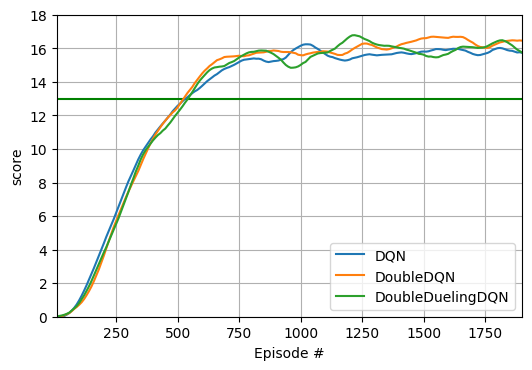

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
def plotScore(data_paths):
    plt.rcParams["figure.dpi"] = 100.0

    num=10
    b=np.ones(num)/num

    for path in data_paths:
        data_mean10 = np.loadtxt(path[1], usecols=1, delimiter=':', dtype='float')
        data_mean100 = np.convolve(data_mean10, b, mode='same')
        print('At '+ str(np.where(data_mean100 > 13.0)[0][0]*10), 'episode', path[0], 'achieved score 13.0')
        plt.plot(np.linspace(10, 2000, 200, endpoint=True), data_mean100, label=path[0])
    
    plt.ylabel('score')
    plt.xlabel('Episode #')
    plt.legend()
    plt.xlim(10,1900)
    plt.ylim(0,18)
    plt.grid()
    plt.hlines([13.0], 0, 2000, "green", label='13.0')
    plt.show()

data_paths = []
data_paths.append(['DQN','results/01_baseline/drl_project1_baseline.txt'])
data_paths.append(['DoubleDQN','results/02_DoubleDQN/drl_project1_ddqn.txt'])
data_paths.append(['DoubleDuelingDQN','results/03_ddqn_dueling/drl_project1_ddq_dueling.txt'])
plotScore(data_paths)

## Trained agent's behavior

The following GIF shows an episode (with 300 steps) of an agent's behavior at Unitiy Banana environment.
The total reward on this episode is 16 which is an average score of the agent.
The agent successfully identifies yellow banana locations, avoids blue bananas, quickly looks around while it keeps moving forward. 
![step10](files/results/05_screenShots/score16/banana_16L.gif)

Here, values of V(s) and A(s,a) calculated at intermediate Dueling layer are added at the bottom of the picture.

For advantage values A(s,a), the definition of each action is as follows.
0. Move forward
1. Move backward
2. Turn left
3. Turn right

The following pictures show that "Move forward" gets the highest value of A(s,a) because banana is infront of the agent.
Also, we can see that V(s) increases from 3.5120 to 3.9162 when the agent approaches to a banana.

| ![26]| ![32]|
|---|---|
|Step26: V(s)=3.5120 A(s,a)=(0.2880, 0.0991, 0.0048, -0.0323)|Step32: V(s)=3.9162 A(s,a)=(0.3705, -0.0237, 0.0518, -0.1410)|

[26]:files/results/05_screenShots/score16/banana_step26.png
[32]:files/results/05_screenShots/score16/banana_step32.png


When no banana is around the agent but wall, "turn left" and/or "turn right" of A(s,a) values become higher to search the other directions.

<img src="files/results/05_screenShots/score16/banana_step197.png" width="640" >

The trained agent does not use "Move backward", and there are 2 intuitive reasons.
 1. Moving backward decelerates speed.
 2. The agent does not have eyes on its back.

Regarding the first reason, "Move backward" decelerates speed of the agent while "Turn right/left" seems not. To maximize collected bananas, the agent should move at maximum speed, and deceleration is not desirable action. 

Regarding the second reason, details of state values that the agent receives from the environment is not clearly explained, but from the discussion https://github.com/Unity-Technologies/ml-agents/issues/1134, the agent seems to get distance to objects by laders mounted only in front. Therefore, the agent cannot detect bananas and walls when it moves backward.

## Parameter reduction
As an additional experiment, the number of units in hidden layers are reduced to figuring out the minimum size of the model to achieve equivalent results with the model used so far.

|Number of units(Layer1, Layer2) |number of parameters|
|------|-----|
|64, 64| 6917|
|32, 32| 2437|  
|16, 8 |  789|  
|8, 8  |  421|

In [4]:
# The number of parameters above is acquired by the following code
# models = [[64,64],[32,32],[16,8],[8,8]]
# for units in models:
#    dqn_model = QNetwork(states,actions,0,units[0], units[1], useDueling=True).to(device)
#    summary(dqn_model, (1,states,0))

The following cell shows results.
* 32x32 model shows similar or even better performance to 64x64 model.
* 16x8 model reduces parameter to 10% of 64x64 model, but no significant difference in performance.
* 8x8 model learns slower than the other models, but the final score is close to the other models.

The banana environment does not need a complex and deep model to solve it. DQN will demonstrate its potential when learning from pixel, which is an optional challenge of this project and not covered by the report.

At 540 episode DoubleDuelingDQN 64x64 achieved score 13.0
At 480 episode DoubleDuelingDQN 32x32 achieved score 13.0
At 610 episode DoubleDuelingDQN 16x8 achieved score 13.0
At 940 episode DoubleDuelingDQN 8x8 achieved score 13.0


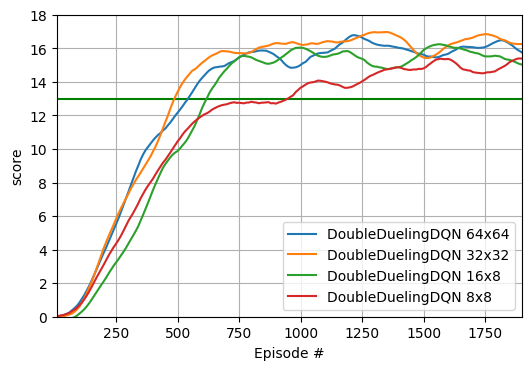

In [5]:
data_paths = []

data_paths.append(['DoubleDuelingDQN 64x64','results/03_ddqn_dueling/drl_project1_ddq_dueling.txt'])
data_paths.append(['DoubleDuelingDQN 32x32','results/04_ddqn_dueling32_32/drl_project1_ddq_dueling32_32.txt'])
data_paths.append(['DoubleDuelingDQN 16x8','results/08_ddqn_dueling_16_8/drl_project1_ddq_dueling_16_8.txt'])
data_paths.append(['DoubleDuelingDQN 8x8','results/09_ddqn_dueling_8_8/drl_project1_ddq_dueling_8_8.txt'])
plotScore(data_paths)

## Ideas for Future Work

In this report, hyperparameters are not changed. Therefore, optimization of hyperparameter could improve the agent's performance. Especially, I would like to see if the agent can improve the performance at the latter learning phase (Episode 1000 to 2000). Currently, scores go up and down by 2 bananas range instead of continuous improvement.

Replacing fully connected layer with convolutional layer may improve the performance.

One technique for improvement would be [Prioritized experience replay](https://arxiv.org/abs/1511.05952). [Let’s make a DQN: Double Learning and Prioritized Experience Replay](https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay) can be refered for the implementation.